# Assignment 1 for FIT5201, Semester 1

**Student Name:**  Siaohsuan, Jiang

**Student ID:**    33029229

In [50]:
# !pip install seaborn

In [49]:
import numpy  as np
from sklearn.datasets import load_diabetes, fetch_california_housing, load_digits, load_breast_cancer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import KDTree
from scipy.stats import mode
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from collections import defaultdict
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures


# 1 Model Complexity and Model Selection

The first 3 questions require the use of two datasets to answer("diabetes" and "housing" datasets). To make the code more organized and avoid repeating lengthy code being called several times, I wrapped the majority of methods and functions into a Class. By doing so, all datasets can be handled as a class. Therefore, to build the class, the code will be executed at the beginning. If necessary, I will also extract the code for explanatory purposes for the following questions.

## Question 1

###  Implement a KNN regressor using the scikit-learn conventations, i.e., in a class with the following skeleton.

Load required dataset in the beginning.

In [ ]:
diabetes = load_diabetes()
housing = fetch_california_housing()

KNN regressor has a hyperparameter K which is set prior to training process. In this regressor, the prediction for a new input is based on the average of its K nearest neighbors. In the KnnRegressor class, we use KDTree, which is a class that allows nearest neighbor searches to be efficient.

In [ ]:
class KnnRegressor:
    """
        Used in Question 1.
        parameter k: nearest neighbors amount
        return: the predict results based on training data
    """
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self

    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = np.mean(neighbour_labels, axis=1, keepdims=True)
        return m.squeeze()

We will also be using LFold when training. LFold is a statistical technique that splits original training data into K folds, and the model will train K times. For each time, it uses a different fold as testing and the other folds as training. One advantage is it improves the problem of limited data, and provides a more accurate performance in general. 

In [ ]:
class LFold:
    def __init__(self, L=5, random_state=None):
        self.L = L

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.L
    
    def split(self, x, y=None, groups=None):
        """
            return L pairs of train and test indices(lists)
            Test indices are not duplicated for each other.
        """
        test_n = int(len(x)/self.L) # test length
        idx_list = list(range(len(x)))
        np.random.seed(1) ## numpy shuffle seed
        np.random.shuffle(idx_list) # shuffle input list
        for i in range(self.L):
            test_idx = idx_list[i*test_n: i*test_n+test_n] # making use of loop to get elements in a shuffled list
            train_idx = np.setdiff1d(idx_list, test_idx) # remaining elements are for training
            np.random.shuffle(train_idx)
            yield list(train_idx), test_idx

The KnnRegressorCV employs the `cross_validation` function to obtain the test_score (MSE) result for each K. It updates the best_k based on the minimum mean of test_scores in each iteration.

In [ ]:
class KnnRegressorCV:
    """
        For Question 3.
    """
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.best_k = -1
        
    def fit(self, x, y):
        """
            Select the best k based on the smallest average value. 
            Print out the best K in the end of the function for debugging.
        """
        minimun_mean = -1
        for k in self.ks: # Inner loop
            print(f"Inner loop k={k}", end=" || ")
            result_test_score = KnnAnalysis().cross_validation(KnnRegressor(k), data=x, target=y, cv=self.cv)['test_score']
            new_mean = result_test_score.mean()
            
            if self.best_k == -1: # first loop
                minimun_mean = new_mean
                self.best_k = k
            elif new_mean<minimun_mean: # if mean is smaller, update k
                minimun_mean = new_mean
                self.best_k = k
            else:
                pass
        
        print("\n\nBest K chosen by regressor is: ", self.best_k, "\n")
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)  
        return self
    
    def predict(self, x):
        """
            not used in this assignment.
        """
        _, neighbours = self.x_train_kdtree_.query(x, k=self.best_k)
        neighbours = neighbours.reshape(len(x), self.best_k)
        neighbour_labels = self.y_train_[neighbours]
        m = np.mean(neighbour_labels, axis=1, keepdims=True)
        return m.squeeze()

To make the code more organized, I created a class called KnnAnalysis to handle the analysis tasks. While we only need to process two datasets for this assignment, it is more efficient to use a class object when dealing with a larger number of datasets. This way, we can easily reuse the same code for each dataset without having to rewrite it each time.

In [ ]:
class KnnAnalysis:
    def __init__(self, dataset=diabetes):
        self.data = dataset.data
        self.target = dataset.target
        self.x_train, self.x_test, self.y_train, self.y_test = self.train_test_split(self.data, self.target, train_size=0.6, random_state=None)
        self.regressor = KnnRegressor()
        
    def train_test_split(self, x, y, train_size=0.6, random_state=None):
        """
            split data and target into training and testing by using the fraction of train_size(0.6)
            return: x_train, x_test, y_train, y_test
        """
        RNG = np.random.default_rng(random_state)
        N = len(x)
        N_train = round(N*train_size)
        idx_train = RNG.choice(N, N_train, replace=False)
        idx_test = np.setdiff1d(np.arange(N), idx_train)
        RNG.shuffle(idx_test)
        return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

    def error_mse(self, y_hat, y):
        """
            input: predicted y and original y
            return: MSE value
        """
        n = len(y)
        sum_of_error_square = sum((y - y_hat)**2) # sum of square
        return sum_of_error_square/n # mean sum of square
    
    def cross_validation(self, model, data, target, cv):
        """
            return: a dictionary with two keys(train, test), storing len(LFolds) MSEs results for each input k(model)
        """
        result = {}
        train_score = []
        test_score = []
        for idx_train, idx_test in cv.split(list(range(len(data)))):

            model.fit(data[idx_train], target[idx_train]) # fitting(different fold for each loop)
            
            train_pred = model.predict(data[idx_train])
            train_loss = self.error_mse(train_pred, target[idx_train]) ## standard mean square error
            train_score.append(train_loss) # add mse to the list
            
            test_pred = model.predict(data[idx_test])
            test_loss = self.error_mse(test_pred, target[idx_test]) ## standard mean square error
            test_score.append(test_loss) # add mse to the list

        
        result["train_score"] = np.array(train_score) # len(train_score) == cv.get_n_splits() == L
        result["test_score"] = np.array(test_score) # len(test_score) == cv.get_n_splits() == L
        return result
    
    def nested_cross_validation(self, data, target, cv, ks=list(range(1, 21))):
        """
            return: best ks list. 
        """
        best_ks = [] # save the best k among ks for each fold
        for l, (idx_train, idx_test) in enumerate(cv.split(list(range(len(data))))):
            print(f"----------------------    Outer loop, L No.{l}    ----------------------")
            best_ks.append(KnnRegressorCV(ks=ks, cv=cv).fit(x=data[idx_train], y=target[idx_train]).best_k)
        return best_ks

    def evaluation(self, max_k, data, target, cv):
        """
            Calculate MSE of different L and k combinations
            return: two array(train, test) and one best k, the shape of array is (L, max_k)
        """
        self.max_k = max_k
        self.L = cv.get_n_splits()
        self.test_results = np.zeros(shape=(self.L, max_k))
        self.train_results = np.zeros(shape=(self.L, max_k))
        for k in range(1, max_k+1):
            knn = KnnRegressor(k) # initialize a regressor
            cv_res = self.cross_validation(knn, data, target, cv) # get MSE result(MSE of different L)
            self.test_results[:, k-1] = cv_res['test_score'] # storing results for each k
            self.train_results[:, k-1] = cv_res['train_score']

        self.best_k = np.argmin(self.test_results.mean(axis = 0)) # best K by using minimum MSE mean
        return self.train_results, self.test_results, self.best_k

    def kEffectPlot(self):
        """
            error bar plot to visualize the effect of different k
        """
        ks = np.arange(1, self.max_k+1)
        _, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
        z = (self.L**0.5)/1.96
        axs[0].errorbar(ks, self.train_results.mean(axis=0), yerr=self.train_results.std(axis=0)/z, label='train')
        axs[0].errorbar(ks, self.test_results.mean(axis=0), yerr=self.test_results.std(axis=0)/z, label='test')
        axs[0].legend()
        axs[0].set_xlabel('$k$')
        axs[0].set_ylabel('MSE')
        axs[0].axvline(ks[self.best_k], color='black', linestyle='--', label='best $k$')
        axs[1].errorbar(1/ks, self.train_results.mean(axis=0), yerr=self.train_results.std(axis=0)/z, label='train')
        axs[1].errorbar(1/ks, self.test_results.mean(axis=0), yerr=self.test_results.std(axis=0)/z, label='test')
        axs[1].set_xscale('log')
        axs[1].set_xlabel('$1/k$')
        plt.show()

    def lEffectPlot(self, Ls=[25, 100, 200]):
        """
            error bar plot to visualize the effect of different l
        """
        Ls = Ls
        train_results_L = []
        test_results_L = []

        for l in Ls:
            print('L: ', l)
            train_res, test_res, _ = self.evaluation(max_k=self.max_k, data=self.data, target=self.target, cv=LFold(l))
            train_results_L.append(train_res)
            test_results_L.append(test_res)
        ks = np.arange(1, self.max_k+1)
        _, axs = plt.subplots(1, len(Ls), figsize=(4*len(Ls),4), tight_layout=True, sharey=True)
        
        for i, l in enumerate(Ls):
            z = l**0.5/1.96
            axs[i].set_title(f'$L$={l}')
            axs[i].errorbar(ks, train_results_L[i].mean(axis=0), yerr=train_results_L[i].std(axis=0)/z, label='train')
            axs[i].errorbar(ks, test_results_L[i].mean(axis=0), yerr=test_results_L[i].std(axis=0)/z, label='test')
            axs[i].set_xlabel('$k$')
        axs[0].legend()
        axs[0].set_ylabel('MSE')
        plt.show()


###  To test your implementation

Two objects called D and H were initialized for the diabetes and housing datasets, respectively. Then, two regressors were initialized by setting K to 10 and 3 for the two objects. In the third step, the regressors were fit with training data (x_train) and target values (y_train), which had already been generated in the `__init__` function during object initialization.

In [ ]:
## Initialize Analysis Class
D = KnnAnalysis(diabetes) # diabetes
H = KnnAnalysis(housing) # housing

## Regressor Initialize
D.regressor = KnnRegressor(10)
H.regressor = KnnRegressor(3)

## Fitting
D.regressor.fit(D.x_train, D.y_train)
H.regressor.fit(H.x_train, H.y_train)

Define error function used for calculating error.
```
    def error_mse(self, y_hat, y):
        n = len(y)
        sum_of_error_square = sum((y - y_hat)**2)
        return sum_of_error_square/n
```

Since the target variables of both datasets are not categorical, so instead of using error rate like in Activity 1.1, I will be using **MSE** which is a common method to estimate errors.

Report the training and testing errors for both dataset.

In [ ]:
# Prediction and MSE
train_y_hat_D = D.regressor.predict(D.x_train)
test_y_hat_D = D.regressor.predict(D.x_test)
train_y_hat_H = H.regressor.predict(H.x_train)
test_y_hat_H = H.regressor.predict(H.x_test)

print(f"Diabetes MSE training error: {D.error_mse(train_y_hat_D, D.y_train)}")
print(f"Diabetes MSE testing error: {D.error_mse(test_y_hat_D, D.y_test)}")
print("")
print(f"Housing MSE training error: {H.error_mse(train_y_hat_H, H.y_train)}")
print(f"Housing MSE testing error: {H.error_mse(test_y_hat_H, H.y_test)}")

Diabetes MSE training error: 3029.399811320756
Diabetes MSE testing error: 3044.965875706214

Housing MSE training error: 0.5795599700763573
Housing MSE testing error: 1.2265041472160951


As expected, the loss of the training set is lower than that of the testing set for both datasets.

## Question 2

### I. Implement a L-Fold Cross Validation

Define LFold class for cross validation.
```
class LFold:
    def __init__(self, L=5, random_state=None):
        self.L = L

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.L
    
    def split(self, x, y=None, groups=None):
        """
            return L pairs of train and test indices(lists)
            Test indices are not duplicated for each other.
        """
        test_n = int(len(x)/self.L) # test length
        idx_list = list(range(len(x)))
        np.random.seed(1) ## numpy shuffle seed
        np.random.shuffle(idx_list) # shuffle input list
        for i in range(self.L):
            test_idx = idx_list[i*test_n: i*test_n+test_n] # making use of loop to get elements in a shuffled list
            train_idx = np.setdiff1d(idx_list, test_idx) # remaining elements are for training
            np.random.shuffle(train_idx)
            yield list(train_idx), test_idx
```

LFold class should be generated before KnnAnalysis class, so it has been defined and explained before. 

Test your implementation for correctness by running a simple example like the following.

In [ ]:
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(f"Training:{idx_train}, Testing:{idx_test}")

Training:[12, 4, 7, 17, 0, 8, 1, 11, 9, 18, 19, 13, 15, 14, 5, 2], Testing:[3, 16, 6, 10]
Training:[15, 10, 3, 6, 5, 7, 18, 13, 12, 0, 1, 19, 8, 16, 9, 11], Testing:[2, 14, 4, 17]
Training:[14, 17, 4, 15, 19, 12, 2, 6, 16, 3, 8, 9, 5, 10, 18, 11], Testing:[7, 1, 13, 0]
Training:[13, 16, 5, 6, 11, 1, 8, 7, 12, 4, 17, 2, 10, 3, 14, 0], Testing:[19, 18, 9, 15]
Training:[14, 10, 1, 16, 2, 17, 0, 7, 3, 13, 6, 15, 4, 19, 18, 9], Testing:[8, 12, 11, 5]


The results of the analysis were as expected, with no duplicate indices found across the five testing sets, indicating that the cross-validation was successful in splitting the data into non-overlapping folds."

### II. Use your L-fold CV implementation to systematically test

#### Test the effect of the KNN parameter K by testing all options **from 1 to 50**. Instead of only performing a single training/test split, run your L-Fold CV.

```
    def cross_validation(self, model, data, target, cv):
        """
            return: a dictionary with two keys(train, test), storing len(LFolds) MSEs results for each input k(model)
        """
        result = {}
        train_score = []
        test_score = []
        for idx_train, idx_test in cv.split(list(range(len(data)))):

            model.fit(data[idx_train], target[idx_train]) # fitting(different fold for each loop)
            
            train_pred = model.predict(data[idx_train])
            train_loss = self.error_mse(train_pred, target[idx_train]) ## standard mean square error
            train_score.append(train_loss) # add mse to the list

            test_pred = model.predict(data[idx_test])
            test_loss = self.error_mse(test_pred, target[idx_test]) ## standard mean square error
            test_score.append(test_loss) # add mse to the list

        result["train_score"] = np.array(train_score) # len(train_score) == cv.get_n_splits() == L
        result["test_score"] = np.array(test_score) # len(test_score) == cv.get_n_splits() == L
        return result

```

```
    def evaluation(self, max_k, data, target, cv):
        """
            Calculate MSE of different L and k combinations
            return: two array(train, test) and one best k, the shape of array is (L, max_k)
        """
        self.max_k = max_k
        self.L = cv.get_n_splits()
        self.test_results = np.zeros(shape=(self.L, max_k))
        self.train_results = np.zeros(shape=(self.L, max_k))
        for k in range(1, max_k+1):
            knn = KnnRegressor(k) # initialize a regressor
            cv_res = self.cross_validation(knn, data, target, cv) # get MSE result(MSE of different L)
            self.test_results[:, k-1] = cv_res['test_score'] # storing results for each k
            self.train_results[:, k-1] = cv_res['train_score']

        self.best_k = np.argmin(self.test_results.mean(axis = 0)) # best K by using minimum MSE mean
        return self.train_results, self.test_results, self.best_k
  
```

The KnnAnalysis class includes `cross_validation` and `evaluation`, which are used to evaluate the performance of the KNN regressor on different values of k. The `cross_validation` function performs L-fold cross validation on the training data to calculate the mean squared error (MSE) of the model for each of the L folds. The function then returns a dictionary that saves the L training and testing MSEs respectively for the given k.

The evaluation function uses a loop to call the `cross_validation` function with different values of k and saves the results for each iteration. It then calculates the mean training and testing MSE across all of the k values tested. The function selects the best k value based on the lowest mean testing MSE across all of the folds. This value is saved as best_k.

#### Test functions by using L=5 and k=50 for both dataset. Compute the mean and standard deviation of the MSE.

After running the evaluation() function, I printed out the train and test results for both datasets. I then calculated the mean standard deviation across all values of L.

In [ ]:
train_results_D, test_results_D, best_k_D = D.evaluation(max_k=50, data=D.x_train, target=D.y_train, cv=LFold(5))
print("Diabetes mean and std for each K.")

## mean
print("Mean of train_results:")
print(train_results_D.mean(axis = 0))
print("")
print("Mean of test(val)_results:")
print(test_results_D.mean(axis = 0))
print("")

## Standard deviation
print("Standard deviation of train_results:")
print(train_results_D.std(axis = 0))
print("")
print("Standard deviation of test(val)_results:")
print(test_results_D.std(axis = 0))
print("")


Diabetes mean and std for each K.
Mean of train_results:
[   0.         1771.79787736 2301.95345912 2510.11786557 2742.67833962
 2850.15505765 2899.27048518 2954.5375     3033.45257396 2988.55736792
 3000.24079994 2973.4687369  2993.27218377 3050.99602907 3051.1952369
 3103.86032577 3140.61403669 3164.34799965 3208.16081116 3220.07475
 3230.96398194 3264.68888001 3274.3271213  3276.20752752 3294.41826113
 3305.21463381 3306.628298   3296.39136504 3303.63772912 3329.98340252
 3332.94599277 3321.88362323 3328.81944748 3343.56262405 3352.93514902
 3351.50325239 3353.81641192 3363.41170295 3384.00050116 3402.62980012
 3404.00358782 3413.83917341 3429.73924202 3438.62097351 3450.03529467
 3472.02308824 3490.86518189 3512.24809683 3523.94786449 3526.95038755]

Mean of test(val)_results:
[6933.16603774 4932.20566038 4412.28888889 4061.69316038 3804.99637736
 3687.71457023 3606.0464382  3659.6384434  3632.45595155 3568.77467925
 3481.46383908 3458.02557652 3418.21040527 3439.93211398 3416.4367

In [ ]:
train_results_H, test_results_H, best_k_H = H.evaluation(max_k=30, data=H.x_train, target=H.y_train, cv=LFold(5))
print("Housing mean and std for each K.")

## mean
print("Mean of train_results:")
print(train_results_H.mean(axis = 0))
print("")
print("Mean of test(val)_results:")
print(test_results_H.mean(axis = 0))
print("")

## Standard deviation
print("Standard deviation of train_results:")
print(train_results_H.std(axis = 0))
print("")
print("Standard deviation of test(val)_results:")
print(test_results_H.std(axis = 0))
print("")

Housing mean and std for each K.
Mean of train_results:
[0.         0.42280147 0.60646913 0.71411309 0.78686171 0.84056462
 0.88155863 0.91432946 0.94125516 0.96558437 0.98660062 1.00578067
 1.0234445  1.03847325 1.05152757 1.06461529 1.07569473 1.08594026
 1.09676094 1.10567473 1.11383855 1.12139522 1.12906563 1.13634161
 1.14355228 1.15012126 1.15609124 1.16215349 1.16678492 1.1719817 ]

Mean of test(val)_results:
[1.70557604 1.35443187 1.25976412 1.22544775 1.21247211 1.2048164
 1.19983214 1.19663019 1.19463882 1.19375758 1.19756237 1.2016702
 1.20606495 1.21192964 1.21660713 1.21819373 1.22065016 1.22310014
 1.22751936 1.23020914 1.23389259 1.23676253 1.24078546 1.24431232
 1.24618808 1.24927648 1.25232521 1.25523922 1.2569579  1.258403  ]

Standard deviation of train_results:
[0.         0.00585973 0.00383866 0.00501502 0.00665806 0.00684921
 0.00598214 0.00550424 0.00552534 0.00364096 0.00485967 0.00568174
 0.00638431 0.00669692 0.00650427 0.00645316 0.0070789  0.00606563
 0.0060

We can observe that the standard deviation results are smaller in Housing data than in Diabetes.

#### Report the K for which you found the best test performance (different training size) 

In [ ]:
## Best Test Performance
print("Best Test Performance:")
Q2_2_bestk_D = np.argmin(test_results_D.mean(axis = 0)) ## smallest mean
Q2_2_bestk_H = np.argmin(test_results_H.mean(axis = 0)) ## smallest mean
print("Diabetes: ", Q2_2_bestk_D)
print("Housing: ", Q2_2_bestk_H)

Best Test Performance:
Diabetes:  14
Housing:  9


The question asks for the best **test performance**. <br>I choose the smallest average MSE as the best test performance indicator. 


### III. Plot the mean training and test errors against the choice of K with error bars (using the standard error of the mean)
$$ste = 1.96s / \sqrt{L}$$

#### The effect of the parameter K

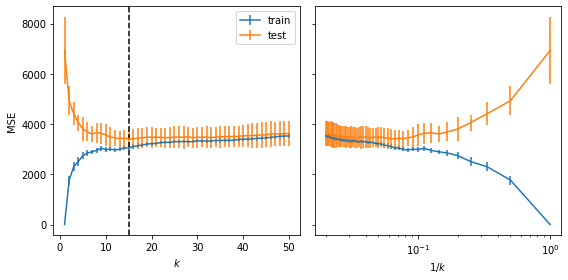

In [ ]:
D.kEffectPlot()

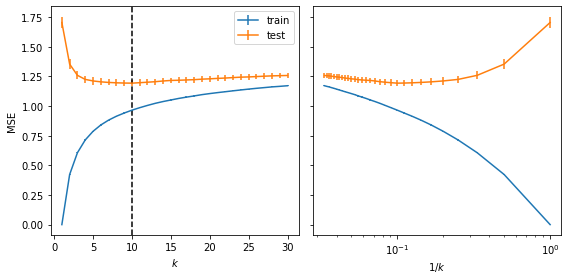

In [ ]:
H.kEffectPlot()

**– The effect of the parameter K. For both datasets, identify regions of overfitting and
underfitting for the KNN model.**

Diabetes<br>
When K is set to 1, the model's performance on the training set is very good with a low mean squared error (MSE). However, its performance on the testing set is very poor with a high MSE. This suggests that the model is overfitting to the training data, meaning that it is capturing the noise in the data rather than the underlying patterns.
As the value of K increases, the testing MSE drops significantly and the length of the error bars, which represent the standard error (ste) of the mean, becomes shorter. This indicates that the overfitting issue is being addressed. The best K value is chosen based on the minimum testing MSE, and a dashed line is used to illustrate it.
After the best K value is reached, the training and testing MSEs start to slightly increase, and the length of the error bars becomes longer. This suggests that the model is possibly underfitting, meaning that it is not capturing all the relevant patterns in the data. In summary, the KNN model performs best when K is around 15, and choosing a higher or lower value can lead to overfitting or underfitting.<br><br>
Housing<br>
The visualization plots display similar results to those of the previous analysis. The dash line representing the best K-value appears around 10, which confirms that choosing a higher or lower value may lead to overfitting or underfitting. However, the standard error (ste) of the mean doesn't display any significant differences when K is larger or smaller.

#### The effect of the parameter L of the CV procedure.

L:  2
L:  10
L:  50


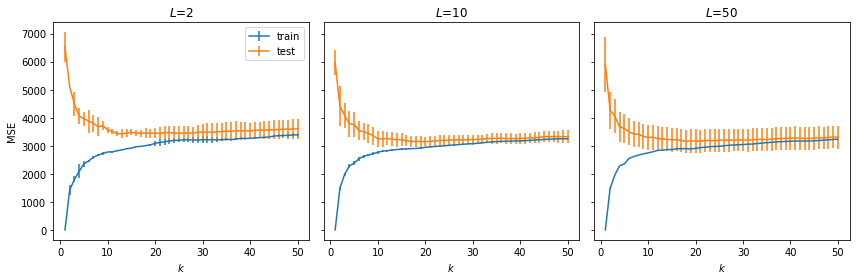

In [ ]:
D.lEffectPlot([2, 10, 50])

L:  2
L:  5
L:  10


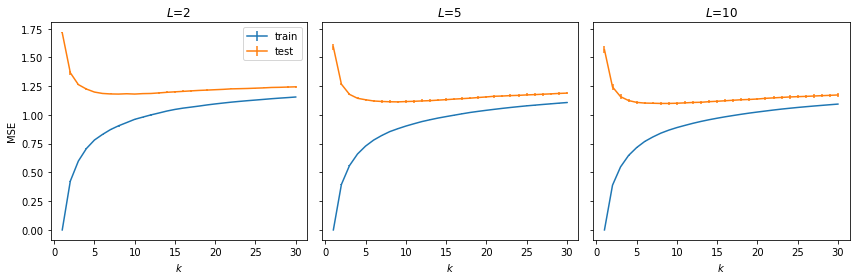

In [ ]:
H.lEffectPlot([2, 5, 10])

**– The effect of the parameter L of the CV procedure. HINT: You might want to repeat
the above process with different values for L to get an intuition of its effect.**

In the Diabetes dataset, we can observe that increasing the value of L in L-fold cross-validation results in a smoother curve for the mean value and a more stable standard error (ste). On the other hand, when we set k to 2, the mean value curve becomes less smooth, and the ste is not stable either. This can be attributed to the small sample size when there are only two folds (i.e., half of the data is taken as testing). This issue may not occur in the Housing dataset since it has much more data than Diabetes, so even with a low value of k, there is still enough data for training.
When performing L-fold cross-validation, it is generally better to have a larger value of k within a certain limit. This is because a larger value of k allows for more validation iterations, and the resulting average can better represent the accuracy of the trained model. However, there is a tradeoff to be made between the number of L values and time/resources required to run the cross-validation. When the number of folds is too large, it can easily overload the machine, leading to significant time and resource costs. For instance, when iterating through 50 folds in the Housing dataset, it takes much time to complete. Nonetheless, the Housing dataset has a large number of samples, resulting in a relatively steady and low ste. Thus, it is best to reduce the number of L values and find the optimal tradeoff between the number of folds and time/resources required.

## Question 3 

### I. Implement a version of the KNN regressor
Automatically chooses an appropriate value of K from a list of options by performing an internal cross-validation on the training set at fitting time.

**Code of KnnRegressorCV for Q3.**
```
class KnnRegressorCV:
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.best_k = -1
        
    def fit(self, x, y):
        minimun_mean = -1
        for k in self.ks: # Inner loop
            print(f"Inner loop k={k}", end=" || ")
            result_test_score = KnnAnalysis().cross_validation(KnnRegressor(k), data=x, target=y, cv=self.cv)['test_score']
            new_mean = result_test_score.mean()
            if self.best_k == -1: # first step in loop
                minimun_mean = new_mean
                self.best_k = k
            elif new_mean<minimun_mean:
                minimun_mean = new_mean
                self.best_k = k
            else:
                pass
        
        print("\n\nBest K chosen by regressor is: ", self.best_k, "\n")
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)  
        return self
    
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.best_k)
        neighbours = neighbours.reshape(len(x), self.best_k)
        neighbour_labels = self.y_train_[neighbours]
        m = np.mean(neighbour_labels, axis=1, keepdims=True)
        return m.squeeze()
```


Initialize a regressor just for testing. Iterate over ks list and got a best k out of the list. The output shows the iteration steps for the different K, and reccomands the best K.

In [ ]:
KnnRegressorCV(ks=list(range(1, 21))).fit(D.x_train, D.y_train)

Inner loop k=1 || Inner loop k=2 || Inner loop k=3 || Inner loop k=4 || Inner loop k=5 || Inner loop k=6 || Inner loop k=7 || Inner loop k=8 || Inner loop k=9 || Inner loop k=10 || Inner loop k=11 || Inner loop k=12 || Inner loop k=13 || Inner loop k=14 || Inner loop k=15 || Inner loop k=16 || Inner loop k=17 || Inner loop k=18 || Inner loop k=19 || Inner loop k=20 || 

Best K chosen by regressor is:  15 



### II. For both datasets from the previous questions, test your KNN regressor with internal CV

```
    def nested_cross_validation(self, data, target, cv, ks=list(range(1, 21))):
        """
            return: best ks list. 
        """
        best_ks = [] # save the best k among ks for each fold
        for l, (idx_train, idx_test) in enumerate(cv.split(list(range(len(data))))):
            print(f"----------------------    Outer loop, L No.{l}    ----------------------")
            best_ks.append(KnnRegressorCV(ks=ks, cv=cv).fit(x=data[idx_train], y=target[idx_train]).best_k)
        return best_ks
```
I have defined a function called `nested_cross_validation` to save the recommended best_ks from the KnnRegressorCV. The function also prints the inner and outer loop steps and the recommended K value for each outer loop iteration.

In [ ]:
outerL = 10 # Split D.x_train(outer) into 10 folds, inner L is set to 5 as default in the KnnRegressorCV()

In [ ]:
best_ks_for_each_L_D = D.nested_cross_validation(data=D.x_train, target=D.y_train, cv=LFold(outerL), ks=list(range(1, 50)))

----------------------    Outer loop, L No.0    ----------------------
Inner loop k=1 || Inner loop k=2 || Inner loop k=3 || Inner loop k=4 || Inner loop k=5 || Inner loop k=6 || Inner loop k=7 || Inner loop k=8 || Inner loop k=9 || Inner loop k=10 || Inner loop k=11 || Inner loop k=12 || Inner loop k=13 || Inner loop k=14 || Inner loop k=15 || Inner loop k=16 || Inner loop k=17 || Inner loop k=18 || Inner loop k=19 || Inner loop k=20 || Inner loop k=21 || Inner loop k=22 || Inner loop k=23 || Inner loop k=24 || Inner loop k=25 || Inner loop k=26 || Inner loop k=27 || Inner loop k=28 || Inner loop k=29 || Inner loop k=30 || Inner loop k=31 || Inner loop k=32 || Inner loop k=33 || Inner loop k=34 || Inner loop k=35 || Inner loop k=36 || Inner loop k=37 || Inner loop k=38 || Inner loop k=39 || Inner loop k=40 || Inner loop k=41 || Inner loop k=42 || Inner loop k=43 || Inner loop k=44 || Inner loop k=45 || Inner loop k=46 || Inner loop k=47 || Inner loop k=48 || Inner loop k=49 || 

Best 

Inner loop k=1 || Inner loop k=2 || Inner loop k=3 || Inner loop k=4 || Inner loop k=5 || Inner loop k=6 || Inner loop k=7 || Inner loop k=8 || Inner loop k=9 || Inner loop k=10 || Inner loop k=11 || Inner loop k=12 || Inner loop k=13 || Inner loop k=14 || Inner loop k=15 || Inner loop k=16 || Inner loop k=17 || Inner loop k=18 || Inner loop k=19 || Inner loop k=20 || Inner loop k=21 || Inner loop k=22 || Inner loop k=23 || Inner loop k=24 || Inner loop k=25 || Inner loop k=26 || Inner loop k=27 || Inner loop k=28 || Inner loop k=29 || Inner loop k=30 || Inner loop k=31 || Inner loop k=32 || Inner loop k=33 || Inner loop k=34 || Inner loop k=35 || Inner loop k=36 || Inner loop k=37 || Inner loop k=38 || Inner loop k=39 || Inner loop k=40 || Inner loop k=41 || Inner loop k=42 || Inner loop k=43 || Inner loop k=44 || Inner loop k=45 || Inner loop k=46 || Inner loop k=47 || Inner loop k=48 || Inner loop k=49 || 

Best K chosen by regressor is:  37 

----------------------    Outer loop, L

In [ ]:
best_ks_for_each_L_H = H.nested_cross_validation(data=H.x_train, target=H.y_train, cv=LFold(outerL), ks=list(range(1, 21)))

----------------------    Outer loop, L No.0    ----------------------
Inner loop k=1 || Inner loop k=2 || Inner loop k=3 || Inner loop k=4 || Inner loop k=5 || Inner loop k=6 || Inner loop k=7 || Inner loop k=8 || Inner loop k=9 || Inner loop k=10 || Inner loop k=11 || Inner loop k=12 || Inner loop k=13 || Inner loop k=14 || Inner loop k=15 || Inner loop k=16 || Inner loop k=17 || Inner loop k=18 || Inner loop k=19 || Inner loop k=20 || 

Best K chosen by regressor is:  9 

----------------------    Outer loop, L No.1    ----------------------
Inner loop k=1 || Inner loop k=2 || Inner loop k=3 || Inner loop k=4 || Inner loop k=5 || Inner loop k=6 || Inner loop k=7 || Inner loop k=8 || Inner loop k=9 || Inner loop k=10 || Inner loop k=11 || Inner loop k=12 || Inner loop k=13 || Inner loop k=14 || Inner loop k=15 || Inner loop k=16 || Inner loop k=17 || Inner loop k=18 || Inner loop k=19 || Inner loop k=20 || 

Best K chosen by regressor is:  7 

----------------------    Outer loop, L 

#### Report on the (mean) k value that is chosen by the KNN regressor with internal cross-validation and whether it corresponds to the best.

In [ ]:
## Mean and Mode k
print("Diabetes")
print("Mean k: ", sum(best_ks_for_each_L_D)/len(best_ks_for_each_L_D))
print("Mode k: ", max(set(best_ks_for_each_L_D), key=best_ks_for_each_L_D.count))
print("")
print(f"Best K in outer test set: {Q2_2_bestk_D}")

Diabetes
Mean k:  21.9
Mode k:  13

Best K in outer test set: 14


In [ ]:
## Mean and Mode k
print("Housing")
print("Mean k: ", sum(best_ks_for_each_L_H)/len(best_ks_for_each_L_H))
print("Mode k: ", max(set(best_ks_for_each_L_H), key=best_ks_for_each_L_H.count))
print("")
print(f"Best K in outer test set: {Q2_2_bestk_H}")

Housing
Mean k:  8.1
Mode k:  8

Best K in outer test set: 9


The results from the Housing dataset are consistent with the theory, as the recommended values from the mean k value are close to the best K found in Question 2. However, in the Diabetes dataset, there were some differences. Upon closer inspection, it was discovered that when the randomstate was set to different values, the mean k value varied as well. This inconsistency is likely due to the smaller size of the Diabetes dataset, which results in a less stable standard error. As a result, the inner cross-validation process often recommends higher values for K, which can cause the mean k value to become larger. Overall, these findings emphasize the importance of carefully selecting K and considering dataset size when conducting cross-validation.

# 2 Probabilistic Machine Learning

## Question 4

### I. Implement a Python function that simulates the experiment.

In [ ]:
## Box 
red = ['a', 'a', 'a', 'o', 'o', 'o', 'o', 'o']
blue = ['a', 'a', 'a', 'a', 'o', 'o', 'o', 'o']
yellow = ['a', 'o']

Define a function to simulate a process of selecting a ball from the one of three boxes. The function will return a string with box color as prefix and fruit name as suffix. ('a' represent apple, 'o' represent oranges)

In [ ]:
def simulation():
    """
        generator obtained via numpy.random.get_default_rng
        return: one string of box color and fruit as an output sample
    """
    rng = np.random.default_rng(seed=None)
    first_select = rng.integers(low=0, high=3, size=1) ## randomly select one box
    if first_select == 0: ## red
        second_select = rng.integers(low=0, high=len(red), size=1)[0] ## randomly select one ball
        return 'red_'+red[second_select]
    elif first_select == 1: ## blue
        second_select = rng.integers(low=0, high=len(blue), size=1)[0]
        return 'blue_'+blue[second_select]
    else: ## yellow
        second_select = rng.integers(low=0, high=len(yellow), size=1)[0]
        return 'yellow_'+yellow[second_select]

To simulate the process 10000 times, I use a loop and save the results in a dictionary. The `simulation` function's return value is used as the dictionary key. If the key is not present in the dictionary, I initialize a new key with a value of 1. Otherwise, I increment the value of the existing key by 1.

In [ ]:
loop_n = 10000 # sample
output_count = {} # storing output
for _ in range(loop_n):
    outputString = simulation()
    if outputString not in output_count.keys():
        output_count[outputString] = 1
    else:
        output_count[outputString] += 1

Output shows the distribution of ball selection.

In [ ]:
output_count

{'red_o': 2066,
 'blue_a': 1678,
 'red_a': 1225,
 'yellow_a': 1665,
 'blue_o': 1651,
 'yellow_o': 1715}

### II. If the picked fruit is an apple, what is the probability that it was picked from the yellow box?


$$P(Yellow \mid Apple)=\frac{P(Apple \mid Yellow) P(Yellow)}{P(Apple)}=\frac{\frac{1}{3}\frac{1}{2}}{\frac{1}{3}\frac{3}{8}+\frac{1}{3}\frac{4}{8}+\frac{1}{3}\frac{1}{2}}=\frac{4}{11}=0.3636363636363637$$

Making use of simulating result, devide the probability of Apple from Yellow by the probability of Apple.

In [ ]:
print("Simulation result:")
print(output_count["yellow_a"]/(output_count["red_a"]+output_count["blue_a"]+output_count["yellow_a"]))

Simulation result:
0.364492119089317


In [ ]:
print("Theoretical calculation result:")
print((0.5/3)/(0.375/3 + 0.5/3 + 0.5/3))

Theoretical calculation result:
0.3636363636363637


The simulation result is close to the theoretical result.

# 3 Ridge Regression

### Question 5 

#### I. Given the gradient descent algorithms for linear regression (discussed in Chapter 2 of Module 2), derive weight update steps of stochastic gradient descent (SGD) for linear regression with L2 regularisation norm. You should provide the steps of SGD.

We know that the error function for linear regression is $ \begin{align*} E(\mathbf{w}) &= \frac{1}{2n} \sum_{n=1}^N (t_n - y(\mathbf{x_n}, \mathbf{w}))^2 \end{align*}$, and then we add penalty part to the error function.
\begin{align*}
E(\mathbf{w}) &= \frac{1}{2n} \sum_{n=1}^N (t_n - y(\mathbf{x_n}, \mathbf{w}))^2 + \frac{\lambda}{2}\|\mathbf{w} \|^2\\
&= \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2 + \frac{\lambda}{2}\|\mathbf{w} \|^2
\end{align*}
The derivative with respect to $w$ will be 
\begin{equation*}
\nabla E(\mathbf{w}) = \frac{1}{n} \Phi^T(\Phi \mathbf{w} - \mathbf{t})  + \lambda\mathbf{w}\enspace 
\end{equation*}
Refer to SGD lecture slides, we can approximate gradient function by making use of small batch size:
\begin{aligned}
\nabla E(\boldsymbol{w}) - \lambda\mathbf{w} & =-\boldsymbol{\Phi}^T(\boldsymbol{t}-\boldsymbol{\Phi} w) \\
& =-\sum_{n=1}^N\left(t_n-\boldsymbol{w} \cdot \boldsymbol{\phi}\left(\boldsymbol{x}_{\boldsymbol{n}}\right)\right) \boldsymbol{\phi}\left(\boldsymbol{x}_{\boldsymbol{n}}\right) \\
& \approx-\sum_{i=1}^b\left(t_{n_i}-\boldsymbol{w} \cdot \boldsymbol{\phi}\left(\boldsymbol{x}_{n_i}\right)\right) \boldsymbol{\phi}\left(\boldsymbol{x}_{n_i}\right) \\
& =-\widetilde{\boldsymbol{\Phi}}^T(\tilde{\boldsymbol{t}}-\widetilde{\boldsymbol{\Phi}} w) \\
& =\widetilde{\nabla} E(\boldsymbol{w}) - \lambda\mathbf{w}
\end{aligned}
In this way(selecting a smaller data randomly), it still have $\mathbf{E}[\widetilde{\nabla} E(\boldsymbol{w})]=\nabla E(\boldsymbol{w})$ and we can make individual update very cheap. <br>
To minimize the error, we use a combination of the previous gradient $\mathbf{w}_{\tau-1}$ and the learning rate $\eta$.(Update the parameter $w$ in every iteration.)
\begin{equation*}
\mathbf{w}_{\tau} = \mathbf{w}_{\tau-1} - \eta \widetilde{\nabla} E(\mathbf{w}_{\tau-1})
\end{equation*}
We keep updating $\mathbf{w}_{\tau}$ until $\|\mathbf{w}_\tau - \mathbf{w}_{\tau-1}\| \leq \epsilon$.
Then we can assume that the difference between gradient and the bottom of error function has been small enough, so we break the loop.

#### II. Using the analytically derived gradient from Step I, implement either a direct or a (stochastic) gradient descent algorithm for Ridge Regression (use again the usual template with init , fit, and predict methods.

The SGD regressor performs gradient descent in its `fit` function by iterating to update the model weights. Since SGD uses a smaller training size, we randomly select a given batch size. 
In this implementation, the default value for $\lambda$ is set to 0 and Ridge penalty is included in the gradient part as follows:
```
        self.lamb*self.w_[tau-1])
```
Finally, the loop breaks if the norm difference is smaller than epsilon, indicating that the difference is small enough to stop training.

In [ ]:
class SGDRidgeLinearRegressor:

    def __init__(self, lamb=0, batch_size=16, eta=0.9, tau_max=100000, epsilon=0.00001, random_state=None):
        self.lamb = lamb
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        
    def fit(self, x, y): # set lambda = 0.1
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            idx = RNG.choice(n, size=self.batch_size, replace=True) # Randomly select batch
            grad = (x[idx].T.dot(x[idx].dot(self.w_[tau-1])-y[idx]))/self.batch_size + self.lamb*self.w_[tau-1] # gradient  
            self.w_[tau] = self.w_[tau-1] - self.eta*grad # update weight_tau

            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon: # break if difference < epsilon
                break
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)

#### III. Study the effect of the L2-regularization on the training and testing errors, using the synthetic data generator from Activity 2.3.

In [ ]:
def f(x):
    return np.sin(5*np.pi*x)/(1+2*x)

def make_additive_noise_data(n, f, a, b, noise=0.1**0.5, random_state=None):
    """
        Synthetic data
    """
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y

def plot_function(f, a, b, models=[], data=None, ax=None, ax_labels=True, legend=True):
    ax = plt.gca() if ax is None else ax
    xx = np.linspace(a, b, 200).reshape(-1, 1)
    if len(models)==1:
        ax.fill_between(xx.squeeze(), f(xx).squeeze(), models[0].predict(xx).squeeze(), alpha=0.3)
        ax.plot(xx, models[0].predict(xx), label='$y$')
    if len(models) > 1:
        for model in models:
            ax.plot(xx, model.predict(xx), color='gray', alpha=0.5)
    ax.plot(xx, f(xx), color='black', label='$f$')
    if data is not None:
        x, y = data
        ax.scatter(x, y, marker='.', color='black', label='data')
    if ax_labels:
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
    if legend: ax.legend()
    ax.margins(x=0)


##### a. Consider the ridge regression model for each λ in {10−10+9i/100, . . . , 10−1: 0 ≤ i ≤ 100} by creating a pipeline of your implemented ridge regressor with a polynomial feature transformer with degree 5.

Making use of `make_pipeline` function and trying to initialize a pipeline object. 

In [ ]:
lambda_list = np.geomspace(10**-10, 0.1, 101, endpoint=True) # create sequence of lambda
degree = 5
make_pipeline(PolynomialFeatures(degree), SGDRidgeLinearRegressor(lamb=lambda_list[0]))

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('sgdridgelinearregressor',
                 <__main__.SGDRidgeLinearRegressor object at 0x7f98546d81c0>)])

##### b. Fit the model ten times (resampling a training dataset of size 20 each time) for all choices of λ.

In [ ]:
reps = 10
models_rep = defaultdict(list)
train_error = np.zeros(shape=(reps, len(lambda_list)))
test_error = np.zeros(shape=(reps, len(lambda_list)))
def mse_error(y_pred, y_real):
    return sum((np.array(y_pred)-np.array(y_real))**2)/len(y_pred)

for rep in range(reps):
    print(f"rep:{rep}")
    x_train, y_train = make_additive_noise_data(20, f, -0.3, 0.3, random_state=rep) # generate train data
    x_test, y_test = make_additive_noise_data(5, f, -0.3, 0.3, random_state=rep) # generate test data
    x_train = x_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    for l, lamb in enumerate(lambda_list): # for each lambda
        model = make_pipeline(PolynomialFeatures(degree), SGDRidgeLinearRegressor(lamb=lamb)) # initialize a model
        model.fit(x_train, y_train.squeeze()) # model fit
        train_error[rep][l] = mse_error(model.predict(x_train), y_train.squeeze()) # get train error
        test_error[rep][l] = mse_error(model.predict(x_test), y_test.squeeze()) # get test error
        models_rep[lamb].append(model) # save a model

rep:0
rep:1
rep:2
rep:3
rep:4
rep:5
rep:6
rep:7
rep:8
rep:9


When we set a smaller learning rate, the above process could be a lot faster, but would not fit and predict data well. I have chosen to use $\eta = 0.9$ for the SGD model which would be a little bit time-consuming but would have some good results!

Getting mean of predictions for each lambda which will be using in the visualization. 

In [ ]:
x_all = np.linspace(-0.3, 0.3, 3000).reshape(-1, 1)
predictions = np.zeros(shape=(len(lambda_list), reps, len(x_all)))

for i, lamb in enumerate(lambda_list): # for each lambda
    for r, model in enumerate(models_rep[lamb]): # for each model
        predictions[i, r, :] = model.predict(x_all).squeeze()

means = np.zeros(shape=(len(lambda_list), len(x_all)))
for i in range(len(lambda_list)):
    means[i, :] = predictions[i, :, :].mean(axis = 0)

Visualize 10 curves of the repititions, one mean of the 10 repititions, and one curve of real value for each lambda.
To analyze the data, I visualized a plot with 10 curves for the repetitions, as well as the mean of the 10 repetitions for each value of lambda. Additionally, I added a black curve of the real value. 

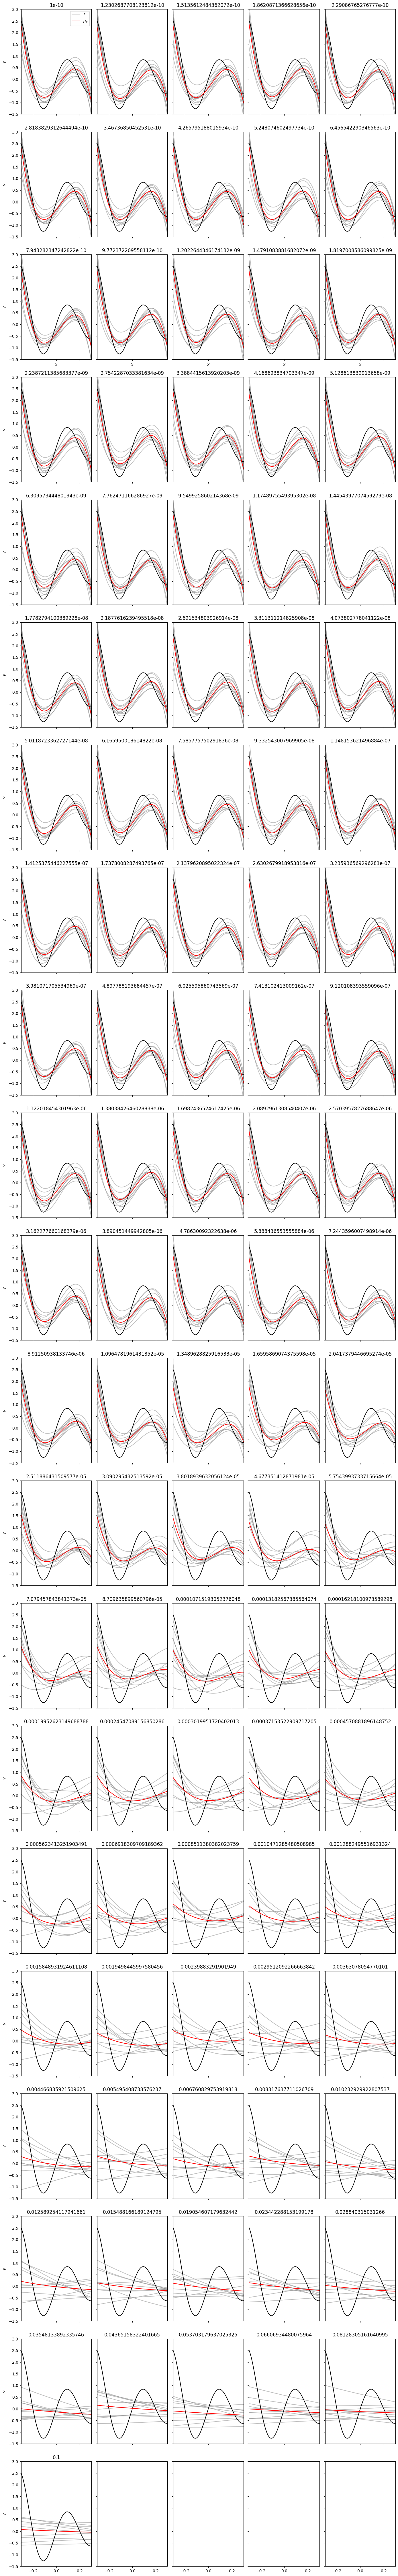

In [ ]:
_, axs = plt.subplots(21, 5, tight_layout=True, sharex=True, sharey=True, figsize=(14, 90))
for i, lamb in enumerate(lambda_list):
    ax = axs[i//5][i%5]
    plot_function(f, -0.3, 0.3, models_rep[lamb][:10], legend=False, ax_labels=False, ax=ax)
    ax.plot(x_all, means[i, :], color='red', label='$\mu_y$')
    ax.set_title(lambda_list[i])
    ax.margins(x=0)
axs[0, 0].set_ylim(-1.5, 3)
axs[0, 0].legend()
for i in range(21): axs[i, 0].set_ylabel('$y$')
for j in range(5): axs[2, j].set_xlabel('$x$')
plt.show()

As lambda increases, the simulated curves tend to deviate further away from the real curve. That's because the increase of $\lambda$ will cause the optimization process to prioritize reducing the weights of the model to avoid overfitting, which can lead to higher bias. Therefore, the value of lambda should be carefully chosen to achieve an optimal balance between model complexity and generalization.

##### c. Create a plot of mean squared errors (use different colors for the training and testing errors), where the x-axis is log lambda and y-axis is the error. Discuss λ, model complexity, and error rates, corresponding to underfitting and overfitting, by observing your plot.

Let's have a look at the shape of train MSE that we calculated. There are a total of 10 x 101 MSE values, corresponding to the 10 repetitions and 101 lambda values used in the analysis. The output matrix shows the mean mse across all errors for 101 lambda.

In [ ]:
train_error.shape, train_error.mean(axis=0)

((10, 101),
 array([0.21000803, 0.21498175, 0.21179995, 0.20611907, 0.21117772,
        0.20891562, 0.20638395, 0.20672667, 0.21788994, 0.20956671,
        0.20668845, 0.20695865, 0.20817164, 0.20758232, 0.20634314,
        0.2108904 , 0.2127425 , 0.2076509 , 0.22054563, 0.21311494,
        0.2109426 , 0.2113344 , 0.21434073, 0.2079045 , 0.2172636 ,
        0.21026519, 0.2054151 , 0.2046829 , 0.20824739, 0.21794051,
        0.2118887 , 0.20704734, 0.20494672, 0.20746346, 0.21046435,
        0.21033234, 0.20950731, 0.21127658, 0.20868862, 0.20908084,
        0.21976065, 0.20983869, 0.2127677 , 0.21039134, 0.21542022,
        0.2237426 , 0.22522158, 0.219023  , 0.24342917, 0.22091594,
        0.22999472, 0.23886333, 0.24156033, 0.27067537, 0.26632832,
        0.27566179, 0.30074164, 0.31966401, 0.3318163 , 0.35884992,
        0.37309499, 0.40279501, 0.4497123 , 0.48137389, 0.51062123,
        0.52709642, 0.55683897, 0.58950038, 0.60156896, 0.62973042,
        0.65488419, 0.65472579, 0.67

Trying to get the mean squared deviation.

In [ ]:
mean_squared_deviations = ((predictions - f(x_all).squeeze())**2).mean(axis=1).mean(axis=1)
mean_squared_deviations

array([0.24196315, 0.26078072, 0.2364769 , 0.23121296, 0.25022294,
       0.22189692, 0.22813038, 0.22876767, 0.26215294, 0.24731392,
       0.22866071, 0.23166098, 0.24011859, 0.23674571, 0.22375618,
       0.24842127, 0.23746788, 0.23595939, 0.27038065, 0.24200927,
       0.24634578, 0.2312387 , 0.2456886 , 0.24067161, 0.25380435,
       0.23631925, 0.23186054, 0.22955829, 0.23567828, 0.2509893 ,
       0.24646999, 0.23511723, 0.22813719, 0.23524116, 0.22175908,
       0.23578095, 0.238086  , 0.22954161, 0.23873422, 0.23172439,
       0.22329913, 0.2275702 , 0.24505172, 0.23901798, 0.25475469,
       0.267498  , 0.2495733 , 0.2445976 , 0.25941097, 0.25715923,
       0.27124488, 0.28976171, 0.28907167, 0.29438145, 0.31209835,
       0.30564144, 0.33227888, 0.39792621, 0.42258444, 0.44016291,
       0.45050247, 0.49597526, 0.53913463, 0.62129312, 0.63856802,
       0.63977307, 0.68915443, 0.72370015, 0.73124398, 0.78871801,
       0.77256921, 0.80871256, 0.81230555, 0.85049239, 0.80485

Visualize the mean of train error, test error, and squared deviation.

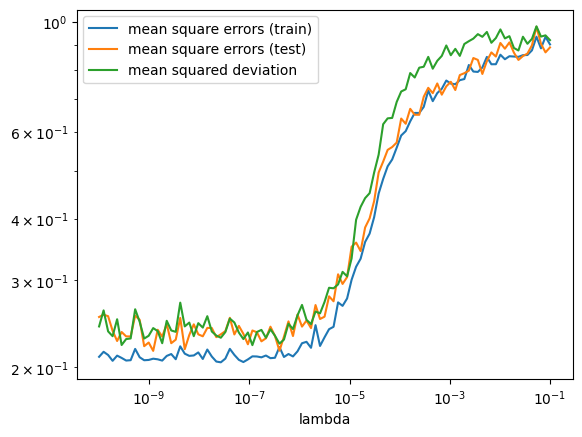

In [ ]:
plt.plot(lambda_list, train_error.mean(axis=0), label='mean square errors (train)')
plt.plot(lambda_list, test_error.mean(axis=0), label='mean square errors (test)')
plt.plot(lambda_list, mean_squared_deviations, label='mean squared deviation')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('lambda')
plt.legend()
plt.show()

Trying to get the bias and variance according to the formula to evaluate model performance.
\begin{equation*}
\mathbf{E}(h(X)-y(X))^2 = \underbrace{\mathbf{E}(h(X)-\mu_y(X))^2}_\text{squared bias} + \underbrace{\mathbf{E}(y(X)- \mu_y(X))^2}_\text{variance} \enspace .
\end{equation*}

In [ ]:
biases = ((means - f(x_all).squeeze())**2).mean(axis=1)
variances = ((predictions.swapaxes(0, 1) - means)**2).mean(axis=0).mean(axis=1)

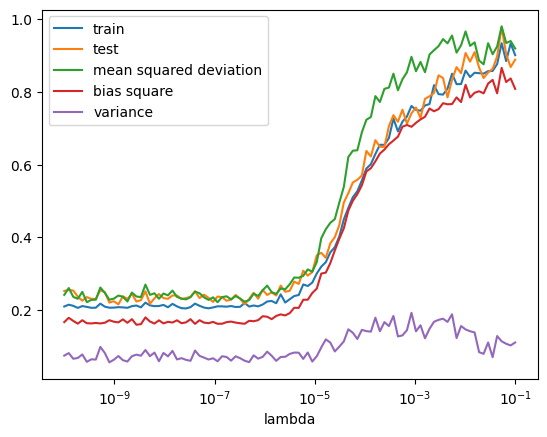

In [ ]:
plt.plot(lambda_list, train_error.mean(axis=0), label='train')
plt.plot(lambda_list, test_error.mean(axis=0), label='test')
plt.plot(lambda_list, mean_squared_deviations, label='mean squared deviation')
plt.plot(lambda_list, biases, label='bias square')
plt.plot(lambda_list, variances, label='variance')
plt.xscale('log')
plt.xlabel('lambda')
plt.legend()
plt.show()

Before $\lambda=10^{-5}$, the models showed stable bias, variance, train and test error. There was no evidence of overfitting or underfitting at this stage. However, after this value, the train error, test error, and bias began to increase. The high bias and a little bit growing variance indicated that the models were underfitting. These results were consistent with the findings in part b, where the curves did not fit well to the real curve when $\lambda$ is high.

# 4 Multiclass Perceptron

## Question 6

#### I. Implement the multiclass perceptron as explained above using the usual template.

In the `fit` unction, it initializes the weights by using a normal distribution with random state (if given). It then iterates over the training data in a random order, calculates the predicted label using the current weight, and updates the weight if the predicted label is not the same as the actual label. This process continues until the maximum number of iterations (tau_max) is reached or the error rate is less than the tolerable error (epsilon). During each iteration, the current weight and the index of the considered training point are saved to the respective traces.

The inner loop number count for each case is stored in the event count matrix.

In [ ]:
class Perceptron:
    """
        used to perform binary classification using the Perceptron algorithm.
    """
    
    def __init__(self, eta=0.01, tau_max=200000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state
        self.event_count = np.zeros(shape=(10, 10))

    def fit(self, x, y):
        """
            Input: input data (x) and their corresponding labels (y).
        """
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        k = len(np.unique(y)) # k classes(10)


        self.w_trace_ = np.empty((self.tau_max, k, p))     # trace of weights during training
        self.xy_idx_trace_ = np.empty((self.tau_max, k), int) # trace of considered training point indices
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0, :, :] = RNG.normal(size=(k, p)) # initializes the weights 
        terminate = False
        
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n),size = n ,replace = False)
            for i in range(n):

                predict_y = self.predict(x[order][i]) # predict y
                real_y = y[order][i] # get real y
                self.event_count[predict_y, real_y]  = self.event_count[predict_y, real_y] + 1 ## inner loop number count for each case
                if predict_y != real_y: # if predict != real, then update weights
                    self.w_[predict_y] = self.w_[predict_y] - self.eta * x[order][i] # reduce the weights of wrong class
                    self.w_[real_y] = self.w_[real_y] + self.eta * x[order][i] # increase the weights of right class
                
                self.w_trace_[tau+1] = self.w_ # trace the weights
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        """
            Predicts its label by multiplying it with the current weight and returning the index of the maximum value.
        """
        if len(x.shape) == 1:
            pred = np.argmax(x.dot(self.w_.T), axis=0)
        else:
            pred = np.argmax(x.dot(self.w_.T), axis=1)

        return pred


#### II. Evaluate your algorithm using the digits dataset provided through the function load digits in sklearn.datasets. This is a classification problem with 10 classes corresponding to the digites 0 to 9 (see the scikit-learn online documentation for more information). Perform an 80/20 train/test split and report your train and test error rates for three different learning rates, η = 0.01, η = 0.1, and η = 0.9 (setting max iterations to 200000 and error tolerance to 0.005). Also report the number of iterations of the inner loops that have been performed in each case.

Perform and 80/20 train/test split. 

In [4]:
def train_test_split_material(x, y, train_size=0.8, random_state=None):
    """
        split data and target into training and testing by using the fraction of train_size(0.6)
        return: x_train, x_test, y_train, y_test
    """
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]


In [ ]:
digits = load_digits()
digit_xtrain, digit_xtest, digit_ytrain, digit_ytest = train_test_split_material(x=digits.data, y=digits.target, train_size=0.8, random_state=1)

Initialize and fit a perceptron object with $\eta = 0.01, 0.1, 0.9$.

In [ ]:
## initialze two objects with different eta
perceptron_001 = Perceptron(eta=0.01, tau_max=200000, epsilon=0.005, random_state=0).fit(digit_xtrain, digit_ytrain)
perceptron_01 = Perceptron(eta=0.1, tau_max=200000, epsilon=0.005, random_state=0).fit(digit_xtrain, digit_ytrain)
perceptron_09 = Perceptron(eta=0.9, tau_max=200000, epsilon=0.005, random_state=0).fit(digit_xtrain, digit_ytrain)

Report your train and test error rates for three different learning
rates

In [ ]:
from sklearn.metrics import zero_one_loss
## eta = 0.01
train_error = zero_one_loss(perceptron_001.predict(digit_xtrain), digit_ytrain) # train error rate
test_error = zero_one_loss(perceptron_001.predict(digit_xtest), digit_ytest) # test error rate
print("------------------Eta = 0.01------------------")
print(f"Train Error Rate: {train_error}")
print(f"Test Error Rate: {test_error}")
## eta = 0.1
train_error = zero_one_loss(perceptron_01.predict(digit_xtrain), digit_ytrain) # train error rate
test_error = zero_one_loss(perceptron_01.predict(digit_xtest), digit_ytest) # test error rate
print("------------------Eta = 0.1-------------------")
print(f"Train Error Rate: {train_error}")
print(f"Test Error Rate: {test_error}")
## eta = 0.9
train_error = zero_one_loss(perceptron_09.predict(digit_xtrain), digit_ytrain) # train error rate
test_error = zero_one_loss(perceptron_09.predict(digit_xtest), digit_ytest) # test error rate
print("------------------Eta = 0.9-------------------")
print(f"Train Error Rate: {train_error}")
print(f"Test Error Rate: {test_error}")

------------------Eta = 0.01------------------
Train Error Rate: 0.003477051460361591
Test Error Rate: 0.03342618384401119
------------------Eta = 0.1-------------------
Train Error Rate: 0.0020862308762169546
Test Error Rate: 0.03064066852367686
------------------Eta = 0.9-------------------
Train Error Rate: 0.004867872044506227
Test Error Rate: 0.0473537604456824


The output show that model perform relatively well when $\eta$=0.1. It has lower both training and testing error rate than the others.

Report the number of iterations of the inner loops that have been performed in each case.

I print out the number of iterations first, and then use a heatmap to visualize the prediction results. The x-axis representing the real values and the y-axis representing the predicted values. It involves 10X10 possible events, ranging from a predicted value of 0 and a real value of 0 to a predicted value of 9 and a real value of 9.

Loops stops when tau wquals to: 51768.0



[Text(0.5, 23.52222222222222, 'Real class'),
 Text(50.722222222222214, 0.5, 'Predict Class')]

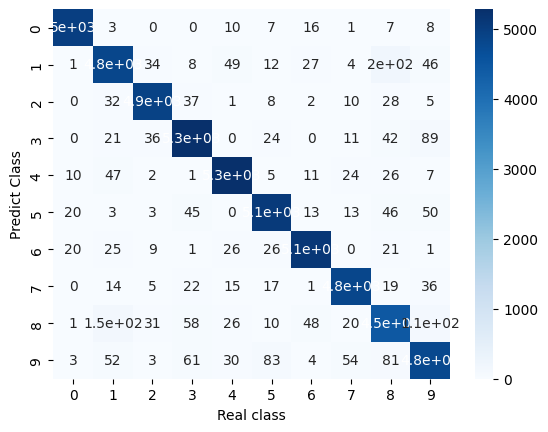

In [ ]:
## number of iterations with eta = 0.01
print(f"Loops stops when tau wquals to: {sum(sum(perceptron_001.event_count))}", end="\n\n")
sns.heatmap(perceptron_001.event_count, annot=True, cmap='Blues').set(xlabel='Real class', ylabel='Predict Class')

Loops stops when tau wquals to: 48892.0



[Text(0.5, 23.52222222222222, 'Real class'),
 Text(50.722222222222214, 0.5, 'Predict Class')]

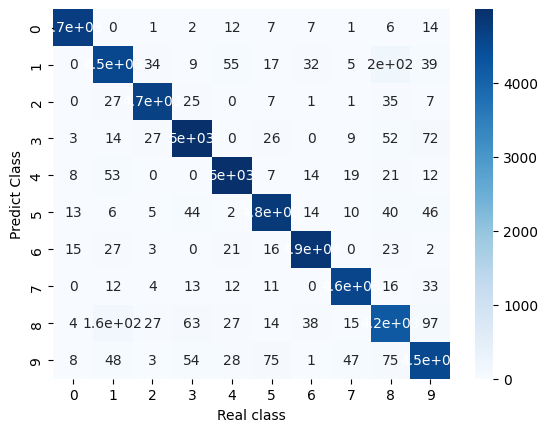

In [ ]:
## number of iterations with eta = 0.1
print(f"Loops stops when tau wquals to: {sum(sum(perceptron_01.event_count))}", end="\n\n")
sns.heatmap(perceptron_01.event_count, annot=True, cmap='Blues').set(xlabel='Real class', ylabel='Predict Class')

Loops stops when tau wquals to: 51768.0



[Text(0.5, 23.52222222222222, 'Real class'),
 Text(50.722222222222214, 0.5, 'Predict Class')]

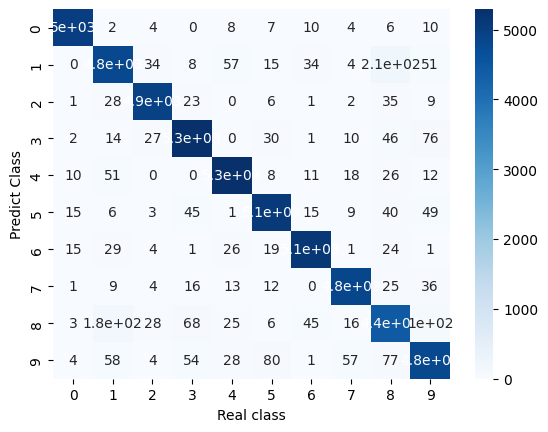

In [ ]:
## number of iterations with eta = 0.9
print(f"Loops stops when tau wquals to: {sum(sum(perceptron_09.event_count))}", end="\n\n")
sns.heatmap(perceptron_09.event_count, annot=True, cmap='Blues').set(xlabel='Real class', ylabel='Predict Class')

Although the output indicates positive results with good performance across all models, upon closer inspection of the confusion matrix, it is evident that the model tends to misclassify the digits 1 and 8 more frequently.

#### III. Finally, for each learning rate, draw a plot of the training and test error as the number of iterations of the inner loop increases. Explain how the errors behave as the training data increases and how this is effected by the learning rate. Comment on what setting was the most efficient.

Getting test and train error rates for the visuzlizations.

In [ ]:
## eta = 0.01
test_errors_001 = np.array([zero_one_loss(np.argmax(digit_xtest.dot(w.T), axis=1), digit_ytest) for w in perceptron_001.w_trace_])
train_errors_001 = np.array([zero_one_loss(np.argmax(digit_xtrain.dot(w.T), axis=1), digit_ytrain) for w in perceptron_001.w_trace_])
## eta = 0.1
test_errors_01 = np.array([zero_one_loss(np.argmax(digit_xtest.dot(w.T), axis=1), digit_ytest) for w in perceptron_01.w_trace_])
train_errors_01 = np.array([zero_one_loss(np.argmax(digit_xtrain.dot(w.T), axis=1), digit_ytrain) for w in perceptron_01.w_trace_])
## eta = 0.9
test_errors_09 = np.array([zero_one_loss(np.argmax(digit_xtest.dot(w.T), axis=1), digit_ytest) for w in perceptron_09.w_trace_])
train_errors_09 = np.array([zero_one_loss(np.argmax(digit_xtrain.dot(w.T), axis=1), digit_ytrain) for w in perceptron_09.w_trace_])


Visualize learning process of Perceptron with three different learning rates. 

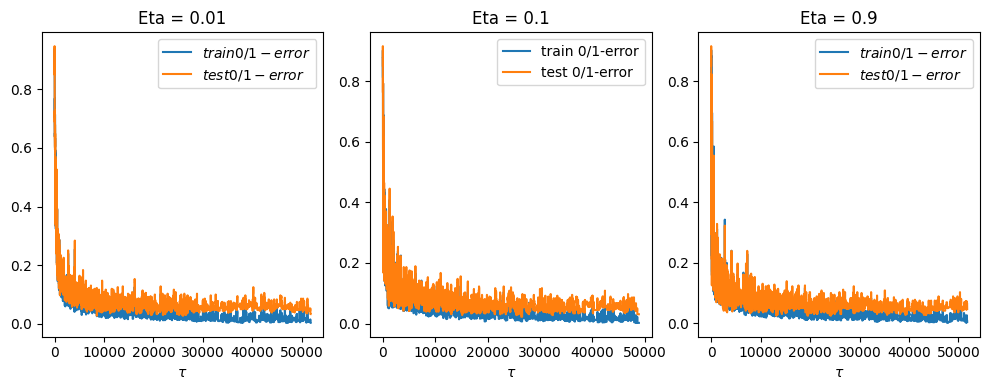

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
axs[0].plot(train_errors_001, label='$train 0/1-error$')
axs[0].plot(test_errors_001, label='$test 0/1-error$')
axs[0].set_xlabel(r'$\tau$')
axs[0].legend()
axs[0].set_title("Eta = 0.01")

axs[1].plot(train_errors_01, label='train 0/1-error')
axs[1].plot(test_errors_01, label='test 0/1-error')
axs[1].set_xlabel(r'$\tau$')
axs[1].legend()
axs[1].set_title("Eta = 0.1")

axs[2].plot(train_errors_09, label='$train 0/1-error$')
axs[2].plot(test_errors_09, label='$test 0/1-error$')
axs[2].set_xlabel(r'$\tau$')
axs[2].legend()
axs[2].set_title("Eta = 0.9")
plt.show()

The testing errors are observed to be high during the first 10,000 iterations. However, as the number of iterations increases, the testing errors gradually become less fluctuant. They remain stable after 20,000 iterations. It is noteworthy that the models with three different learning rates perform similarly. In theory, a small learning rate may update the weights slower, which could cause the gradient to require more time to reach the stationary point. However, in this case, I did not observe a significant impact of learning rate on the training process.

# 5.  Logistic Regression versus Bayes Classifier

## Question 7

### I. Load the breast cancer dataset via load breast cancer in sklearn.datasets, import LogisticRegression from sklearn.linear model, and copy the code from Activity 3.3. for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared). Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance. Note: for logistic regression you can also use the code for the variant with regularisation from Activity 3.2, but this option requires a more careful calibration of the classifier parameters (batch size, max iterations and error tolerance).

In [40]:
from sklearn.model_selection import train_test_split

## load and split data
cancer = load_breast_cancer()
# cancer_xtrain, cancer_xtest, cancer_ytrain, cancer_ytest = train_test_split_material(x=cancer.data, y=cancer.target, train_size=0.8, random_state=0)
cancer_xtrain, cancer_xtest, cancer_ytrain, cancer_ytest = train_test_split(cancer.data, cancer.target, train_size=0.8, random_state=0)
cancer_ytrain.shape

(455,)

In [41]:
## code from Activity 3.3
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov
        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            cond_probs[:, c] = multivariate_normal.pdf(x, self.cond_means_[c], self.cond_covs_[c], allow_singular=True)
        marginal_probs = (cond_probs*self.class_priors_).sum(axis=1)
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

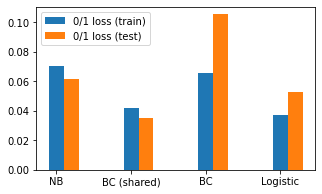

In [42]:
from sklearn.metrics import zero_one_loss, log_loss
from sklearn.linear_model import LogisticRegression

def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
#     plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
#     plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

# nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(cancer_xtrain, cancer_ytrain)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(cancer_xtrain, cancer_ytrain)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(cancer_xtrain, cancer_ytrain)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(cancer_xtrain, cancer_ytrain)
LogisticModel = LogisticRegression(max_iter=10000).fit(cancer_xtrain, cancer_ytrain) # The meaning of the error message is lbfgs cannot converge because the iteration number is limited and aborted. ConvergenceWarning: lbfgs failed to converge (status = 1)

models = [nb, bc_shared, bc, LogisticModel]
model_names = ['NB', 'BC (shared)', 'BC', 'Logistic']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, cancer_xtrain, cancer_ytrain, cancer_xtest, cancer_ytest)
plt.legend()
plt.show()


Based on the loss plot, the BC (Shared) Model outperforms the other three models, with lower training and testing losses. Following closely behind are the Logistic and NB models. Surprisingly, despite having the most parameters, the BC model has the highest testing loss, which is worth noting.

### II. Implement an experiment where you test the performance for increasing training sizes of N = 5, 10, . . . , 500. For each N sample 10 training sets of the corresponding size, fit all models, and record training and test errors. Hints: You can use training test split from sklearn.model selection with an integer parameter for train size (do not forget to use shuffle=True). Again make the repetitions the inner loop to assure that all models are trained on the same training set for a given repetition and sample size.

In this section, we need to store a large number of values (error rates) using several layers of loop. To accomplish this, I have initialized two objects, train_loss and test_loss, with the shape (5, 100, 10) to keep track of the train and test errors. The dimensions of the objects represent 10 repetitions by 100 different training sizes by 5 models. 

In [43]:
Ns = range(5, 505, 5) # samples
training_sets = 10 # train set
train_loss = np.empty((len(models), len(Ns), training_sets))
test_loss = np.empty((len(models), len(Ns), training_sets))

# train_test_loss
for index, n in enumerate(Ns):
    for i in range(training_sets):
        cancer_xtrain, cancer_xtest, cancer_ytrain, cancer_ytest = train_test_split(cancer.data, cancer.target, train_size=n, random_state=None)
        train_loss_tmp = [] # train_loss of 5 models
        test_loss_tmp = [] # test_loss of 5 models
        for model in models:

            model.fit(cancer_xtrain, cancer_ytrain)
            train_loss_tmp.append(zero_one_loss(cancer_ytrain, model.predict(cancer_xtrain)))
            test_loss_tmp.append(zero_one_loss(cancer_ytest, model.predict(cancer_xtest)))
        
        ## append train test loss for a given traing size n and training set
        train_loss[:, index, i] = np.array(train_loss_tmp)
        test_loss[:, index, i] = np.array(test_loss_tmp)
    print(n, end="->") ## print out training size
print("Done!")

5->10->15->20->25->30->35->40->45->50->55->60->65->70->75->80->85->90->95->100->105->110->115->120->125->130->135->140->145->150->155->160->165->170->175->180->185->190->195->200->205->210->215->220->225->230->235->240->245->250->255->260->265->270->275->280->285->290->295->300->305->310->315->320->325->330->335->340->345->350->355->360->365->370->375->380->385->390->395->400->405->410->415->420->425->430->435->440->445->450->455->460->465->470->475->480->485->490->495->500->Done!


### III. Create suitable plots that compare the mean train and test performances of all models as a function of training size. There is no need to include error bars if that makes the plot too hard to read.

We have obtained the error rates for each repetition of every training size for every model. Currently, I aim to plot the mean error rates for different models based on the training size. Additionally, the standard deviation of the error rates across the 10 repetitions is also worth considering. To achieve this, I utilized various list objects to store the required values of different 5 models across 100 training sizes.

In [44]:
## storing train test mean loss for different train size of 5 models
models_mean_train_loss = [] # ultimate shape (5, 100)
models_mean_test_loss = []

models_std_train_loss = [] # ultimate shape (5, 100)
models_std_test_loss = []

for i, name in enumerate(model_names):
    ## train test loss matrix for a model
    model_train_loss = train_loss[i, :, :]
    model_test_loss = test_loss[i, :, :]
    
    ## train test mean loss for different train size of a model
    models_mean_train_loss.append(model_train_loss.mean(axis=1))
    models_mean_test_loss.append(model_test_loss.mean(axis=1))
    
    ## train test std loss for different train size of a model
    models_mean_train_loss.append(model_train_loss.std(axis=1))
    models_mean_test_loss.append(model_test_loss.std(axis=1))


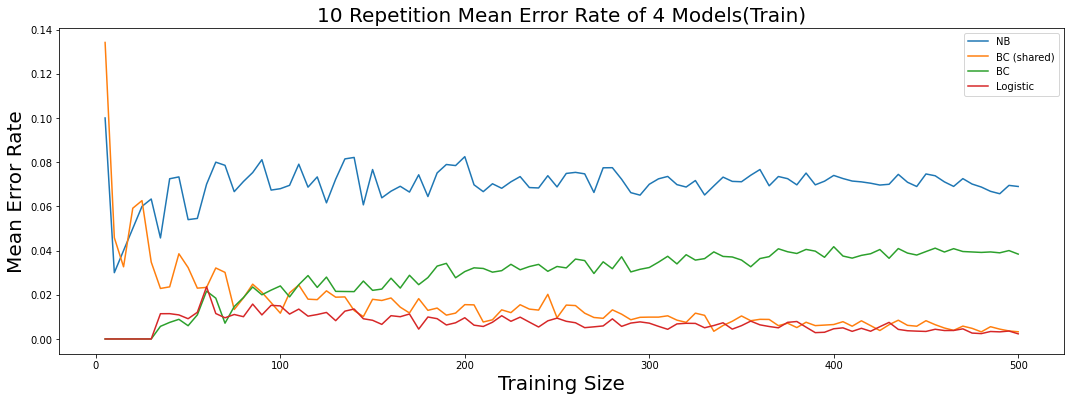

In [45]:
plt.figure(figsize=(18,6))
for i, name in enumerate(model_names):
    plt.errorbar(Ns, models_mean_train_loss[i], label=name)

plt.xlabel("Training Size", fontsize=20)
plt.ylabel("Mean Error Rate", fontsize=20)
plt.title("10 Repetition Mean Error Rate of 4 Models(Train)", fontsize=20)
plt.legend()
plt.show()

In [46]:
plt.figure(figsize=(18,6))
for i, name in enumerate(model_names):
    plt.errorbar(Ns, models_mean_test_loss[i], label=name)

plt.xlabel("Training Size", fontsize=20)
plt.ylabel("Mean Error Rate", fontsize=20)
plt.title("10 Repetition Mean Error Rate of 4 Models(Test)", fontsize=20)
plt.legend()
plt.show()

Outputs look nice.

### IV. Formulate answers to the following questions:

#### a. What happens to each classifiers train and test performance when the number of training data points is increased?

In theory, having more data improves the model's training. Consistent with this theory, as the size of the training set increases, particularly when it exceeds 100, all four models become more stable, and their learning curves flatten out.

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

Logistic regression shows a spike in testing error when the training size is low, indicating that the model is not stable. NB and BC in this case did not perform well when the training size is low, particularly the BC model, which has a low error rate on training but a high error rate on the test, suggesting overfitting.
Based on the charts, the logistic model and BC (shared) perform relatively well. They not only have low training and testing errors, but also very low training and testing ste. More importantly, there is no significant divergence between the curves of train and test, which is a good sign. 

I would say when the training size is small, I recommand use BC(shared) model and when the training size is big, both BC(shared) and Logisti are very suitable.

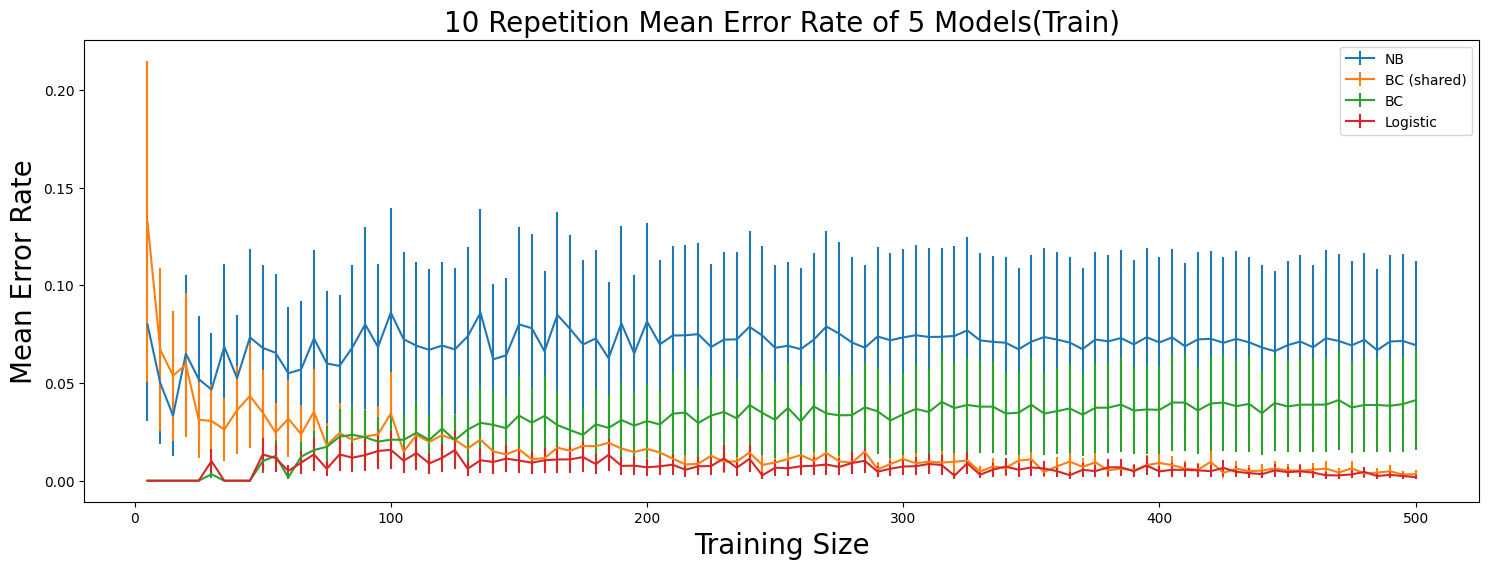

In [ ]:
plt.figure(figsize=(18,6))
z = (10**0.5)/1.96
for i, name in enumerate(model_names):
    plt.errorbar(Ns, models_mean_train_loss[i], yerr=models_mean_train_loss[i]/z, label=name)

plt.xlabel("Training Size", fontsize=20)
plt.ylabel("Mean Error Rate", fontsize=20)
plt.title("10 Repetition Mean Error Rate of 5 Models(Train)", fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(18,6))
z = (10**0.5)/1.96
for i, name in enumerate(model_names):
    plt.errorbar(Ns, models_mean_test_loss[i], yerr=models_mean_test_loss[i]/z, label=name)

plt.xlabel("Training Size", fontsize=20)
plt.ylabel("Mean Error Rate", fontsize=20)
plt.title("10 Repetition Mean Error Rate of 5 Models(Test)", fontsize=20)
plt.legend()
plt.show()

#### c. Justify your observations by providing some speculations and possible reasons. Hint: Think about model complexity and the fundamental concepts of machine learning covered in Module 1. In particular think of the number of parameters that each model has to learn and what assumptions the models make about the data which could be violated.

The observed performance differences between Bayesian classifiers and logistic regression in small training sizes could be due to the different assumptions that each model makes about the data. When the training size is low, Bayesian classifiers generally outperform logistic regression as they incorporate prior information about the distribution, while logistic regression relies solely on the training data.

The overfitting observed in the BC model may be due to its greater complexity compared to the other models. The BC model may be fitting the training data too closely and failing to generalize well to new data.

The performance of the logistic regression model and the BC(shared) model in larger training sizes could be attributed to their relatively lower complexity compared to the BC model. BC has more parameters that some weight might generate noises when training and predicting. The BC(shared) model may perform better than the logistic regression model due to its ability to share parameters across classes, which can lead to improved generalization performance.